In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Your Name and PRN:
- Name: Yogesh Murlidhar Siral
- PRN : 240340128037
- Date: 29/05/2024

# Image Processing with Neural Network
## Assignment A05

## Tensor Flow
- Select number of layers
- Select node in each of the layers
- Choose activation function
- multi-class - Fashion MNIST dataset (all 60000 images)
- Implement one or more of following to achieve max accuracy.
    - L1/ L2 Regularization
    - Dropout
    - Batch Normalization
    - Early stopping
- Save model

In [4]:
###-----------------
### Import Libraries
###-----------------
import os
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [5]:
###-----------------
### Global Variables
###-----------------
inpDir = os.path.join('..', 'input') # Location where input data is stred
outDir = '../output' # Location to store outsputs
modelDir = '../models' # Location of images
subDir = 'fashion_mnist'
logDir = './logs'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE)

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

CMAP = 'brg' # plt.cm.Spectral

plt.rcParams.update(params)


In [6]:
###-----------------
### Hyper Parameters
###-----------------
EPOCHS = 50 # number of epochs
ALPHA = 0.001 # learning rate

BATCH_SIZE = 32
REG_LAMBDA = 0.001
TEST_SIZE = 0.2

# Early Stoping
PATIENCE = 20
LR_PATIENCE = 10
LR_Factor = 0.1 

In [7]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, store them here to use later when plotting the images:

In [8]:

class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

In [9]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device

In [10]:
train_df.columns

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)

In [11]:
train_df.shape, test_df.shape

((60000, 785), (10000, 785))

In [12]:
def split_feature_label(row):
    feature = tf.reshape(row[1:], [28,28,1])

    label = row[0]

    return feature, label

## For Train DataSet

In [13]:
#Converting dataset into tesnorfolow
tmp_df = tf.data.Dataset.from_tensor_slices(train_df)

train_ds = tmp_df.map(split_feature_label)

# # data for validation
# X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0
# y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
# #X_test = X_test/255.0

train_ds = train_ds.batch(BATCH_SIZE)

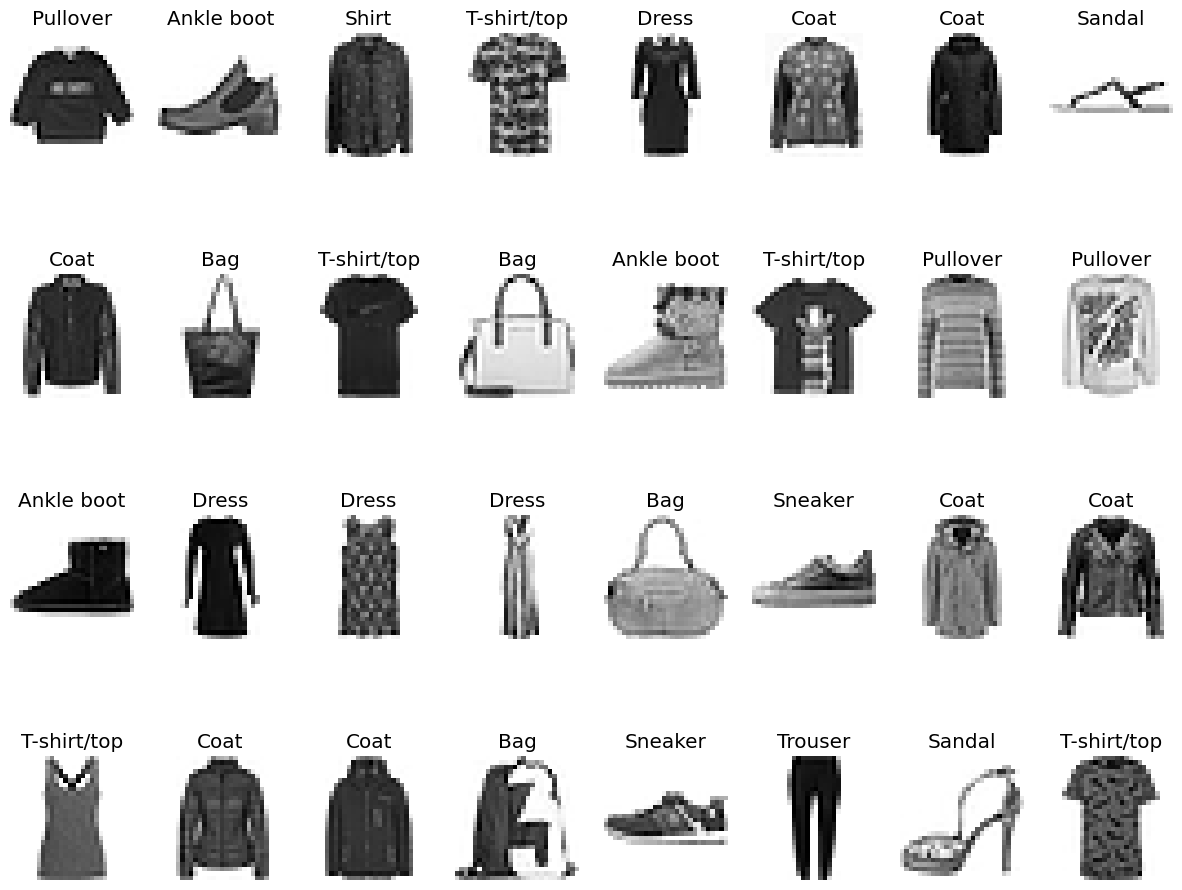

In [14]:

fig = plt.figure(figsize=(15, 12)) # figure size in inches

for images,labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(4, int(BATCH_SIZE//4), i+1)

        plt.imshow(images[i].numpy().astype('uint16'),
                    cmap = plt.cm.binary, 
                   interpolation='nearest') # sgow image on axis

        plt.title(class_names[labels[i].numpy()]) # Addd numbers (class) of images

        #plt.text(2,4, class_names[labels[i].numpy()], color ='b', fontsize = 12)

        plt.axis('off')

plt.show()

## For Test DataSet

In [15]:
# Coverting dataset inyo tenserflow
tmp_df = tf.data.Dataset.from_tensor_slices(test_df)

test_ds = tmp_df.map(split_feature_label)

test_ds = test_ds.batch(BATCH_SIZE)

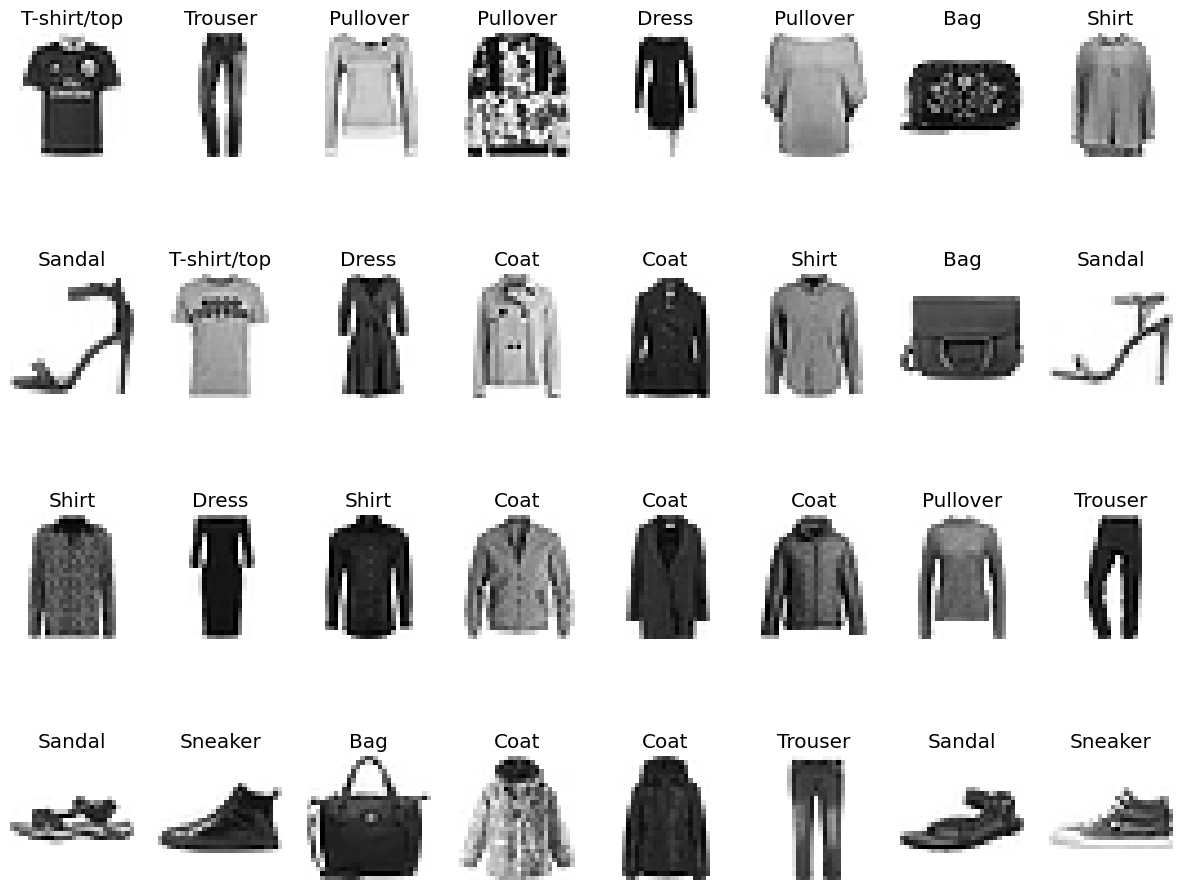

In [16]:

fig = plt.figure(figsize=(15, 12)) # figure size in inches

for images,labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(4, int(BATCH_SIZE//4), i+1)

        plt.imshow(images[i].numpy().astype('uint16'),
                    cmap = plt.cm.binary, 
                   interpolation='nearest') # sgow image on axis

        plt.title(class_names[labels[i].numpy()]) # Addd numbers (class) of images

        #plt.text(2,4, class_names[labels[i].numpy()], color ='b', fontsize = 12)

        plt.axis('off')

plt.show()

In [17]:
for features, labels in train_ds.take(1):
    print (features.shape, labels.shape)

(32, 28, 28, 1) (32,)


In [18]:
for features, labels in train_ds.take(1):
    print (features, labels)

tf.Tensor(
[[[[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  ...

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]]


 [[[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  ...

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]]


 [[[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  [[  0]
   [  0]
   [  0]
   ...
   [  0]
   [  0]
   [  0]]

  ...

  [[  0]
   [  0]
 

In [19]:
for features, labels in test_ds.take(1):
    print (features.shape, labels.shape)

(32, 28, 28, 1) (32,)


In [20]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Prepaere Model

build tf.keras.Sequential model by stcking. chos an optoimizer and loss function

In [21]:
# Model creating

#k_init = tf.keras.initializers.GlorotUniform(seed =  RANDOM_STATE)
k_reg = tf.keras.regularizers.L2(l2 =  REG_LAMBDA)
k_init = None
dor1 = 0.4
dor = 0.3
dor3 = 0.2
dor4 = 0.12

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28],name="inputLayer"),

    # Set Layer1
    tf.keras.layers.Dense(300,
                           kernel_initializer =  k_init,
                           kernel_regularizer = k_reg,
                           name="hiddenLayer1"),

     # BN1
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dor1),
    tf.keras.layers.ReLU(),
    

    # Set Layer2
    tf.keras.layers.Dense(100, 
                          kernel_initializer =  k_init,
                          kernel_regularizer = k_reg,
                          name="hiddenLayer2"),
    # BN2
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dor1),
    tf.keras.layers.ReLU(),
    


    # Output Layer
    tf.keras.layers.Dense(10, activation="softmax", name="outputLayer")
])

In [22]:
checkpoint_path = os.path.join(modelDir, subDir, 'MNIST_DATASET') # save the model

early_stoping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=PATIENCE, # it will contiue for given patience value after that stop
    verbose=2,
    mode='auto',
    restore_best_weights=True, # It restore the best weight before 20 epochs
)

log_dir = os.path.join(logDir,'fit')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [23]:
loss_fn =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True)

optimizer =  tf.keras.optimizers.Adam(learning_rate=ALPHA)
model.compile(optimizer =  optimizer,loss  =  loss_fn,metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (Flatten)        (None, 784)               0         
                                                                 
 hiddenLayer1 (Dense)        (None, 300)               235500    
                                                                 
 batch_normalization (Batch  (None, 300)               1200      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 re_lu (ReLU)                (None, 300)               0         
                                                                 
 hiddenLayer2 (Dense)        (None, 100)               30100     
                                                        

In [25]:
history =  model.fit(train_ds,
                     validation_data=test_ds,
                     batch_size=BATCH_SIZE,
                     epochs=EPOCHS,
                     callbacks = [early_stoping_callback],
                     verbose=2)

Epoch 1/50



c:\Users\Administrator.DAI-PC2\anaconda3\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



1875/1875 - 14s - loss: 0.9639 - accuracy: 0.7792 - val_loss: 0.6510 - val_accuracy: 0.8409 - 14s/epoch - 8ms/step
Epoch 2/50
1875/1875 - 11s - loss: 0.7126 - accuracy: 0.8105 - val_loss: 0.6418 - val_accuracy: 0.8299 - 11s/epoch - 6ms/step
Epoch 3/50
1875/1875 - 11s - loss: 0.6852 - accuracy: 0.8145 - val_loss: 0.5990 - val_accuracy: 0.8527 - 11s/epoch - 6ms/step
Epoch 4/50
1875/1875 - 11s - loss: 0.6757 - accuracy: 0.8152 - val_loss: 0.5983 - val_accuracy: 0.8432 - 11s/epoch - 6ms/step
Epoch 5/50
1875/1875 - 11s - loss: 0.6762 - accuracy: 0.8177 - val_loss: 0.5914 - val_accuracy: 0.8439 - 11s/epoch - 6ms/step
Epoch 6/50
1875/1875 - 11s - loss: 0.6696 - accuracy: 0.8203 - val_loss: 0.5772 - val_accuracy: 0.8518 - 11s/epoch - 6ms/step
Epoch 7/50
1875/1875 - 11s - loss: 0.6656 - accuracy: 0.8220 - val_loss: 0.6159 - val_accuracy: 0.8360 - 11s/epoch - 6ms/step
Epoch 8/50
1875/1875 - 11s - loss: 0.6638 - accuracy: 0.8202 - val_loss: 0.5848 - val_accuracy: 0.8540 - 11s/epoch - 6ms/step
Ep

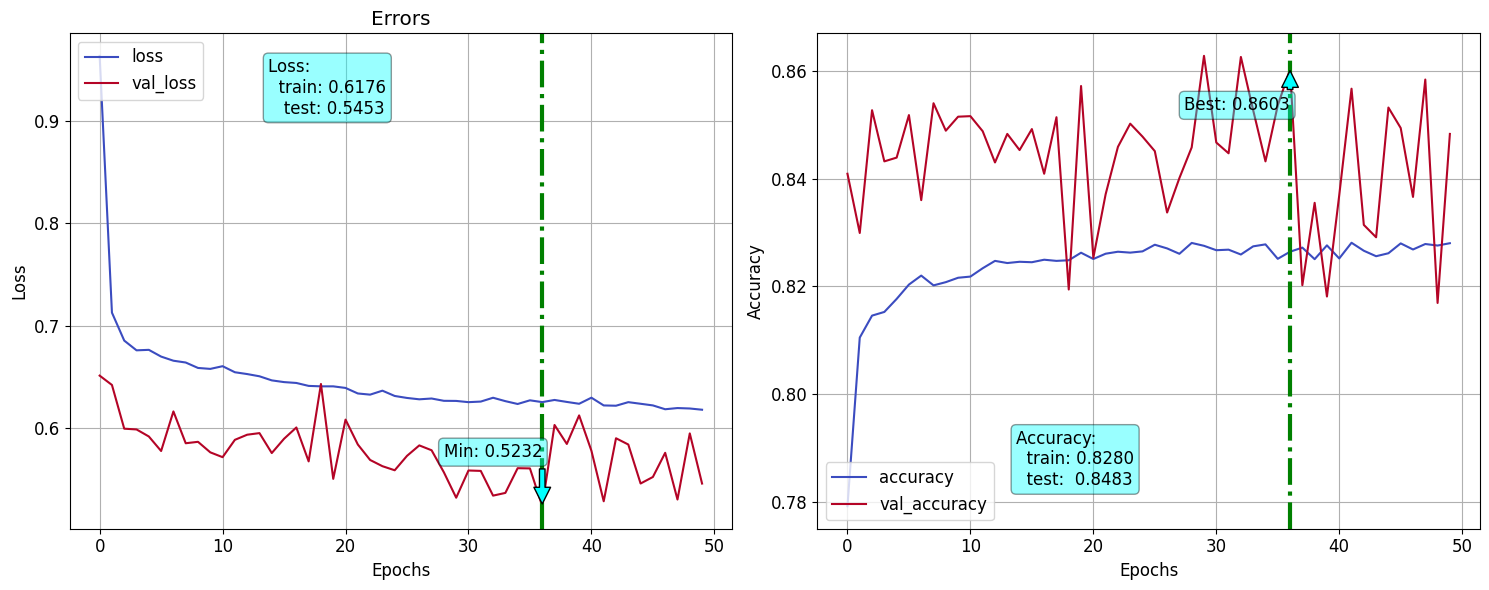

In [26]:
hi = pd.DataFrame(history.history)
fn_plot_tf_hist(hi)

# OutPut
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 inputLayer (Flatten)        (None, 784)               0         
                                                                 
 hiddenLayer1 (Dense)        (None, 300)               235500    
                                                                 
 batch_normalization (Batch  (None, 300)               1200      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 re_lu (ReLU)                (None, 300)               0         
                                                                 
 hiddenLayer2 (Dense)        (None, 100)               30100     
                                                                 
 batch_normalization_1 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 re_lu_1 (ReLU)              (None, 100)               0         
                                                                 
 outputLayer (Dense)         (None, 10)                1010      
...
Total params: 268210 (1.02 MB)
Trainable params: 267410 (1.02 MB)
Non-trainable params: 800 (3.12 KB)